# TODO:

## object oriented
  - simulation (N, x0, y0, r0, T_fire, min_fuel, max_fuel, mu, tf, T_init_fire), method simulate
  - state (X, Y, dx, dy, dt, T, c, u, v), method visualize, défricher(x)
  
  
```
état: initialiser(params état initial)
état: couper la forêt
simulation: initialiser(état initial, paramètres simulation)
simulation: simuler()
simulation: observe (donne integrale de c) (OU simulation: visualizer)
```

f_c(x, params):
    sim = Simulation(params)

In [1]:
%load_ext snakeviz
%load_ext line_profiler

from dataclasses import dataclass, field, InitVar
from typing import List
from copy import deepcopy

from IPython.display import clear_output
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
mpl.rcParams["pcolor.shading"] = "nearest"

# Simulation

In [3]:
def disk(X, Y, x, y, r):
    return (X - x)**2 + (Y - y)**2 <= r**2


def rect(X, Y, xmin, xmax, ymin, ymax):
    return np.logical_and.reduce((xmin < X, X < xmax, ymin < Y, Y < ymax))


def viz(X, Y, T, c, u, v, title=""):
    %matplotlib inline
    fuel = plt.pcolormesh(X, Y, c, cmap=plt.cm.YlGn, vmin=0, vmax=10)
    fuel_cb = plt.colorbar(fuel)
    fuel_cb.set_label("fuel", loc="top")
    
    fire = plt.pcolormesh(X, Y, np.ma.masked_where(np.abs(T) < T_fire, T), cmap=plt.cm.hot, vmin=0, vmax=5)
    #fire_boundary = plt.contour(X, Y, T < T_fire, antialiased=False, levels=[.5], colors="r")
    fire_cb = plt.colorbar(fire)
    fire_cb.set_label("fire", loc="top")
    
    n_arrows = 6
    wind_ind = np.zeros(X.shape, dtype=bool)
    wind_ind[::len(X) // n_arrows, ::len(X) // n_arrows] = True
    plt.quiver(X[wind_ind], Y[wind_ind], u[wind_ind], v[wind_ind])
    
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    clear_output(wait=True)
    plt.show()

In [4]:
# paramètres physique
T_fire = .05
min_fuel, max_fuel = 0, 10
mu = 5e-3

tf = 1.8  # temps final

In [5]:
# paramètres de l'état initial
N = 201
x0 = y0 = .1
r0 = .05
T_init_fire = 5

Champs scalaires :
 - T : température
 - c : combustible
 - b : brulé (booléen)
 
Champ vectoriel:
 - V : vent

In [6]:
def init(N: int, x0: float, y0: float, r0: float) -> "X, Y, dx, dy, dt, T, c, u, v":
    """make the variables at t=0"""
    np.random.seed(0)
    x, dx = y, dy = np.linspace(0, 1, N, retstep=True)
    X, Y = np.meshgrid(x, y, indexing="ij")

    T = np.zeros(X.shape)
    T[disk(X, Y, x0, y0, r0)] = T_init_fire

    c = np.full(X.shape, 5.)
    for i in range(5):
        rr = np.random.uniform(0.1, 0.2)
        xr = np.random.uniform(0.1, 0.9)
        yr = np.random.uniform(0.1, 0.9)
        valr = np.random.uniform(-5, 5)

        c[disk(X, Y, xr, yr, rr)] = valr + c[disk(X, Y, xr, yr, rr)]
    c = np.clip(c, min_fuel, max_fuel)

    u = np.cos(np.pi * Y)
    v = 0.6 * np.sin(np.pi / 2 * (X + 0.2))
    
    dt_c = min(dx, dy) / np.sqrt(u*u + v*v).max()
    dt_d = 1/2 * min(dx, dy)**2 / mu
    dt = min(dt_c, dt_d) / 4
    
    return X, Y, dx, dy, dt, T, c, u, v

In [7]:
def timestep(T, c, u, v, dx, dy, dt) -> "T, c":
    """update the variables"""
    T, c = T.copy(), c.copy()
    back = slice(None, -2)
    mid =  slice(1, -1)
    front = slice(2, None)
    u_mid, v_mid = u[mid,mid], v[mid,mid]
    T_mid = T[mid,mid]
    on_fire = T > T_fire
    
    # calcul des dérivées
    Tx_back = (T_mid - T[back,mid]) / dx
    Tx_front = (T[front,mid] - T_mid) / dx
    Ty_back = (T_mid - T[mid,back]) / dy
    Ty_front = (T[mid,front] - T_mid) / dy
    Txx = (Tx_front - Tx_back) / dx
    Tyy = (Ty_front - Ty_back) / dy
    
    # laplacien, advection, reaction
    diffusion = mu * (Txx + Tyy)
    
    Tx_upwind = Tx_front
    Tx_upwind[u_mid > 0] = Tx_back[u_mid > 0]
    Ty_upwind = Ty_front
    Ty_upwind[v_mid > 0] = Ty_back[v_mid > 0]
    advection = -(Tx_upwind * u_mid + Ty_upwind * v_mid)
    
    reaction_fire = np.zeros(T.shape)
    reaction_fire[np.logical_and(on_fire, c >= 0)] = 10
    reaction_fire[np.logical_and(on_fire, c < 0)] = -5
    
    # mise à jour de la température
    T_mid += dt * ((diffusion + advection) + (reaction_fire * T)[mid,mid])
    c[on_fire] += dt * -100
    
    # condition de neumann au bord
    T[:,0] = T[:,1]
    T[:,-1] = T[:,-2]
    T[0,:] = T[1,:]
    T[-1,:] = T[-2,:]

    return T, c

    
def solve(X, Y, dx, dy, dt, T, c, u, v, max_iter=1e4, viz_every=False) -> "T, c":
    """solve the PDEs, inplace
    if max_iter <= 0, there is no maximum iteration
    if viz_every <= 0, there is no visualization
    """
    for k, t in enumerate(np.arange(dt, tf + dt, dt)):
        T, c = timestep(T, c, u, v, dx, dy, dt)
        
        if viz_every > 0 and k % viz_every == 0:
            viz(X, Y, T, c, u, v, f"{t=:.2f}, {k=}\n{100 * t/tf:.1f}%")
        
        if max_iter > 0 and k > max_iter:
            print(f"{max_iter=} surpassed, stopping")
            break
    return T, c

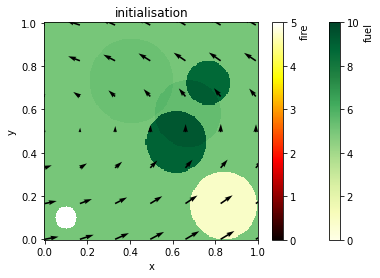

In [8]:
init_state = X, Y, dx, dy, dt, T, c, u, v = init(N, x0, y0, r0)

viz(X, Y, T, c, u, v, "initialisation")

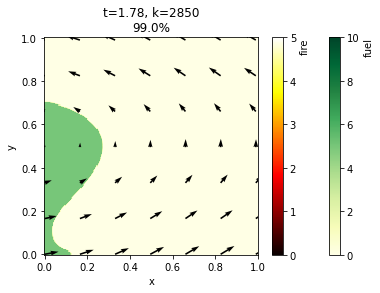

In [9]:
#%lprun -u 1e-6 -f timestep solve(*init_state, max_iter=False)
solve(*init_state, viz_every=50);

# Optimization

In [10]:
params = {
    "N": 100,
    "x0": .1,
    "y0": .1,
    "r0": .05
}


def cut_trees(X, Y, c, x, replace_with) -> "c":
    c = c.copy()
    c[rect(X, Y, *x)] = replace_with
    return c

def f_c(x):
    xmin, xmax, ymin, ymax = x
    
    X, Y, dx, dy, dt, T0, c0, u, v = init(**params)
    c0 = cut_trees(X, Y, c0, x, replace_with=-1)
    T, c = solve(X, Y, dx, dy, dt, T0, c0, u, v)
    
    init_forest_amount = c0.sum() / params["N"]**2
    final_forest_amount = c.sum() / params["N"]**2
    
    forest_cost = init_forest_amount - final_forest_amount
    area_cost = abs(xmax - xmin) * abs(ymax - ymin)
    position_cost = max(0, .2 - ymin)
    
    return forest_cost + 10 * area_cost + 100 * position_cost

In [11]:
x = [.2, .4, .2, .4]
f_c(x)

17.956021743922665